In [1]:
import tensorflow as tf
import numpy as np
from common import create_toy_regression_dataset, plot_regression_model_analysis
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt

from utils import *

In [2]:
def gaussian_nll(y_true, y_pred):
    """
    Gaussian negative log likelihood
    
    Note: to make training more stable, we optimize
    a modified loss by having our model predict log(sigma^2)
    rather than sigma^2. 
    """
    
    y_true = tf.reshape(y_true, [-1])
    mu = y_pred[:, 0]
    si = y_pred[:, 1]
    loss = (si + tf.square(y_true - mu)/tf.math.exp(si)) / 2.0
    return tf.reduce_mean(loss)

def define():
    model = Sequential([
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dropout(.5),
        Dense(2, activation=None)
    ])

    return model

def train(x, y, model, epochs=300):
    optim = tf.keras.optimizers.Adam(1e-3)
    model.compile(loss=gaussian_nll, optimizer = 'Adam')
    model.fit(x, y, 
              batch_size=32,
              epochs=epochs,
              verbose=0)
    return model

def predict(model, x, samples=20):
    '''
    Args:
        model: The trained keras model
        x: the input tensor with shape [N, M]
        samples: the number of monte carlo samples to collect
    Returns:
        y_mean: The expected value of our prediction
        y_std: The standard deviation of our prediction
    '''
    mu_arr = []
    si_arr = []

    for t in range(samples):
        y_pred = model(x, training=True)
        mu = y_pred[:, 0]
        si = y_pred[:, 1]

        mu_arr.append(mu)
        si_arr.append(si)

    mu_arr = np.array(mu_arr)
    si_arr = np.array(si_arr)
    var_arr = np.exp(si_arr)

    y_mean = np.mean(mu_arr, axis=0)
    y_variance = np.mean(var_arr + mu_arr**2, axis=0) - y_mean**2
    y_std = np.sqrt(y_variance)
    return y_mean, y_std

In [3]:
xmin = -10.
xmax = 10.

data = create_toy_regression_dataset(xmin=xmin, xmax=xmax, noise_std=0)
x_gt = data[0]
y_gt = data[1]
x_trn = data[2]
y_trn = data[3]
x_tst = data[4]
y_tst = data[5]

model = define()
model = train(x_trn[:, np.newaxis], y_trn[:, np.newaxis], model)

In [4]:
yhat_mean, yhat_std = predict(model, x_tst[:, np.newaxis], samples=5)

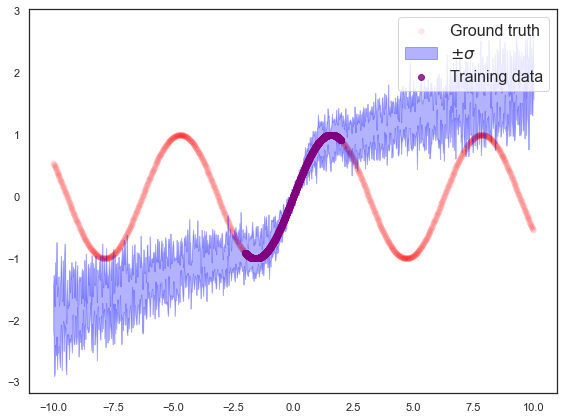

In [5]:
plt.figure(figsize=(8, 6))

plt.scatter(x_gt, y_gt, alpha = 0.1, color = 'red', linewidth = 0.2, label = 'Ground truth')
plt.fill_between(x_tst, (yhat_mean - 1.*yhat_std), (yhat_mean + 1.*yhat_std), color = 'blue', alpha = 0.3, 
                 label = r'$\pm \sigma$')

plt.scatter(x_trn, y_trn, color = 'purple', alpha = 0.8, label = 'Training data')

plt.legend(fontsize = 16)
plt.tight_layout()

#### 2D case

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

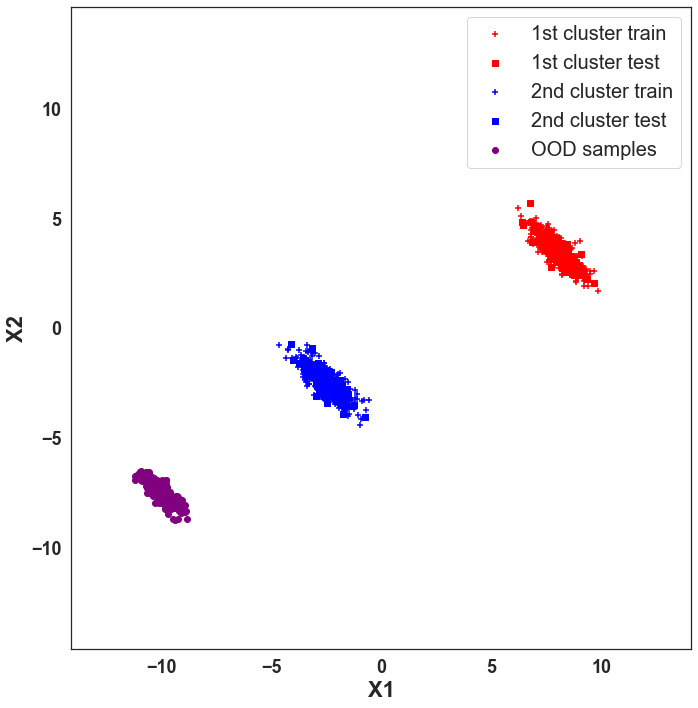

In [7]:
x_train, x_test, y_train, y_test, x_ood, y_ood, x_mesh, y_mesh = make_data()

In [8]:
scalerX, scalerY = MinMaxScaler(), MinMaxScaler()
x_train_norm, y_train_norm = scalerX.fit_transform(x_train), scalerY.fit_transform(y_train)
x_test_norm, y_test_norm = scalerX.transform(x_test), scalerY.transform(y_test)
x_ood_norm, y_ood_norm   = scalerX.transform(x_ood), scalerY.transform(y_ood)
x_mesh_norm = scalerX.transform(x_mesh)

#### If Gaussian loss is used

In [9]:
def define():
    model = Sequential([
        Dense(64, activation='relu'),
        Dropout(.5),
        Dense(64, activation='relu'),
        Dropout(.5),
        Dense(2, activation=None)
    ])

    return model

In [10]:
def train(x, y, model, epochs=300):
    optim = tf.keras.optimizers.Adam(1e-3)
    model.compile(loss=gaussian_nll, optimizer = 'Adam')
    model.fit(x, y, batch_size=64, epochs=epochs, verbose=0)
    return model

In [11]:
model = define()

In [12]:
model = train(x_train_norm, y_train_norm, model, epochs=500)

In [14]:
yhat_mean, yhat_std = predict(model, x_mesh_norm, samples=20)

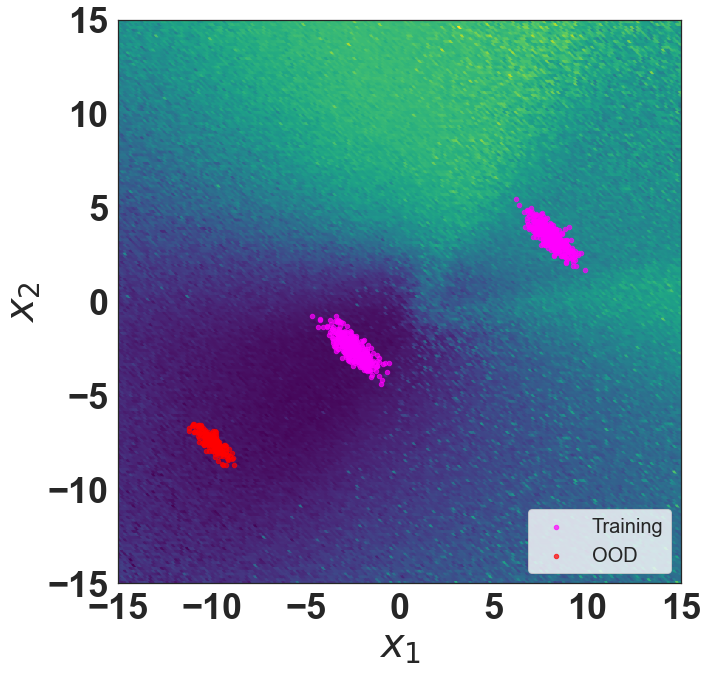

In [15]:
plot_uncertainty_map(x_train, x_ood, x_mesh, yhat_std, 'MC_dropout', False, False)

#### If MSE loss is used

In [31]:
def define():
    model = Sequential([
        Dense(128, activation='relu'),
        Dropout(.1),
        Dense(128, activation='relu'),
        Dropout(.1),
        Dense(128, activation='relu'),
        Dropout(.1),
        Dense(128, activation='relu'),
        Dropout(.1),
        Dense(1, activation=None)
    ])

    return model

In [32]:
def train(x, y, model, epochs=300):
    optim = tf.keras.optimizers.Adam(1e-3)
    model.compile(loss='mean_squared_error', optimizer = 'Adam')
    model.fit(x, y, batch_size=128, epochs=epochs, verbose=0)
    return model

In [33]:
model = define()
model = train(x_train_norm, y_train_norm, model, epochs=1000)

In [34]:
niter = 50
MC_output = np.zeros((len(x_mesh), niter))

In [35]:
for i in range(niter):
    MC_output[:, i] = model(x_mesh_norm, training=True).numpy().flatten()

In [36]:
MC_output = scalerY.inverse_transform(MC_output)

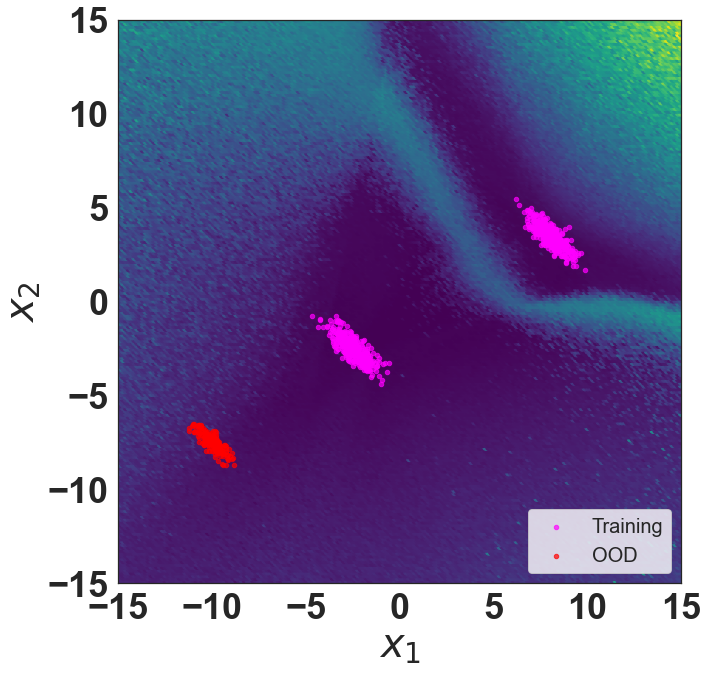

In [37]:
plot_uncertainty_map(x_train, x_ood, x_mesh, np.std(MC_output, axis = 1), 'MC', False, False)